# Data extraction and cleaning for OpenDengue
### Author: Hailey Robertson
### Date: 2024-09-24
### Citations:
- Clarke J, Lim A, Gupte P, Pigott DM, van Panhuis WG, Brady OJ. A global dataset of publicly available dengue case count data. Sci Data. 2024 Mar 14;11(1):296.
- Clarke J, Lim A, Gupte P, Pigott DM, van Panhuis WG, Brady OJ. OpenDengue: data from the OpenDengue database. Version [1.2]. figshare; 2023. Available from: https://doi.org/10.6084/m9.figshare.24259573.


### DONE 
- find NAs at adm2 and adm1 compared to adm0 (8% missing adm1, 44% missing adm2)
- zero-filling – zeroes were most likely previously NAs, but not necessarily 
- dates to dates
- floats to floats
- match on iso3
- observed reporting period differences (1 year, 30 days, 1 week)
- combined place column + geocode


## Imports and constants

In [1]:
# Imports
import requests
import pandas as pd
from datetime import datetime
import os
import numpy as np
import geopandas as gpd
import country_converter as coco
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import font_manager
import seaborn as sns
from brokenaxes import brokenaxes
from geopy.geocoders import Nominatim
import pickle
import time
from dotenv import load_dotenv

load_dotenv()

True

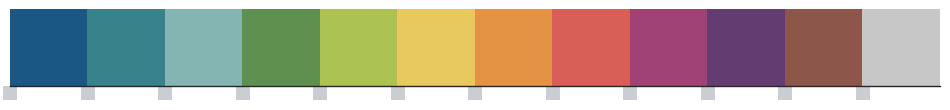

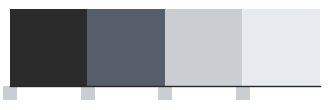

In [91]:
colors = ['#1A5784', '#38828C', '#84B5B2', '#60904F', '#ACC253', '#E7C960', '#E49243', '#D75F58', '#A04275', '#633D71', '#8c564b', '#c7c7c7']
sns.palplot(sns.color_palette(colors))

# Define chart color palette
chart = ['#2C2B2B','#565E69','#CACED3','#E7EAEE']
sns.palplot(sns.color_palette(chart))

# Define constants
figure_size = (20,6)

# Set background
sns.set_context('talk') #change the size from small to medium
sns.set_style('white') #change bg to white

# Add every font at the specified location
font_dir = ['/Users/haileyrobertson/Library/Fonts']
for font in font_manager.findSystemFonts(font_dir):
    font_manager.fontManager.addfont(font)
    
# Set font family globally
plt.rcParams['font.family'] = 'Open Sans'
plt.rcParams['font.weight'] = 'bold'

# Set margins
plt.rcParams['axes.xmargin'] = 0.1
plt.rcParams['axes.ymargin'] = 0.1

# Define list of date formats
zfmts = ['', '%Y','%b\n%Y', '%b', '%b-%d', '%H:%M', '%H:%M']

# Format axes 
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['axes.titlepad'] = 30

# Format ticks
plt.rcParams["xtick.direction"] = "out"
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.minor.size'] = 10
plt.rcParams['xtick.bottom'] = True
plt.rcParams['xtick.color'] = chart[2]
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['xtick.labelcolor'] = chart[1]
plt.rcParams['xtick.labelsize'] = 8

plt.rcParams["ytick.direction"] = "in"
plt.rcParams["ytick.major.pad"] = 0
plt.rcParams["ytick.minor.pad"] = 0
plt.rcParams["ytick.major.size"] = 10
plt.rcParams["ytick.minor.size"] = 10
plt.rcParams["ytick.color"] = chart[2]
plt.rcParams["ytick.major.width"] = 0.1
plt.rcParams["ytick.minor.width"] = 0.1
plt.rcParams["ytick.labelcolor"] = chart[1]
plt.rcParams["ytick.labelsize"] = 8


# Adjust fontdict for title
titlefont = {'family': 'Open Sans',
             'color':  chart[0], 
             'weight': 400,
             'size': 20}

# Set grid style
plt.rcParams['grid.color'] = chart[2]
plt.rcParams['grid.linestyle'] = 'dashed'
plt.rcParams['grid.linewidth']=0.5

# Set legend style
plt.rcParams['legend.frameon'] = False
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['legend.handlelength'] = 1
plt.rcParams['legend.handleheight'] = 1.125



# Set axis labels
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.labelcolor'] = chart[1]

## Cleaning

In [3]:
# Get data from master repo, reset index to access adm_0_name
url = 'https://raw.githubusercontent.com/OpenDengue/master-repo/refs/heads/main/data/raw_data/masterDB_V1.2.csv'
df = pd.read_csv(url, index_col=0, encoding='latin-1').reset_index()

# Convert unstandardized country names into iso3 codes
df["adm_0_iso3"] = coco.convert(names=df["adm_0_name"],to='ISO3', not_found="missing")

# Convert all date columns to datetime
date_cols = ['calendar_start_date', 'calendar_end_date']
df[date_cols] = df[date_cols].apply(pd.to_datetime)

df.head()

,adm_0_name,adm_0_code,adm_1_name,adm_1_code,adm_2_name,adm_2_code,calendar_start_date,calendar_end_date,dengue_total,case_definition_standardised,UUID,adm_0_iso3
0,Argentina,12.0,Salta,445.0,Oran,4781.0,2019-07-21,2019-07-27,2.0,Total,MOH-ARG-2019-Y01-00,ARG
1,Argentina,12.0,Misiones,442.0,Iguazu,4728.0,2019-09-01,2019-09-07,1.0,Total,MOH-ARG-2019-Y01-00,ARG
2,Argentina,12.0,Salta,445.0,Grl. Jose De San Martin,4773.0,2019-07-14,2019-07-20,1.0,Total,MOH-ARG-2019-Y01-00,ARG
3,Argentina,12.0,Jujuy,438.0,Ledesma,4649.0,2019-07-14,2019-07-20,1.0,Total,MOH-ARG-2019-Y01-00,ARG
4,Argentina,12.0,Salta,445.0,Grl. Jose De San Martin,4773.0,2019-06-30,2019-07-06,3.0,Total,MOH-ARG-2019-Y01-00,ARG


In [4]:
# Check for missing iso3 (should be empty)
missing_rows = df[df["adm_0_iso3"] == "missing"]
print(missing_rows)

Empty DataFrame
Columns: [adm_0_name, adm_0_code, adm_1_name, adm_1_code, adm_2_name, adm_2_code, calendar_start_date, calendar_end_date, dengue_total, case_definition_standardised, UUID, adm_0_iso3]
Index: []


In [5]:
# World geometry shapefile, devastating that get_path("naturalearth_lowres") was deprecated 
world = gpd.read_file("../data/ne_110m_admin_0_countries")
world = world.rename(columns={"ADM0_A3":"adm_0_iso3",
                              "ADMIN":"adm_0_name",
                              "geometry":"adm_0_geometry"})
cols = ['adm_0_iso3','adm_0_name','adm_0_geometry']
world = world[cols]
world = world.sort_values(by="adm_0_name")

# Fix known issues in geopandas
world.loc[world['adm_0_name'] == 'France', 'adm_0_iso3'] = 'FRA'
world.loc[world['adm_0_name'] == 'Norway', 'adm_0_iso3'] = 'NOR'
world.loc[world['adm_0_name'] == 'Somaliland', 'adm_0_iso3'] = 'SOM'
world.loc[world['adm_0_name'] == 'Kosovo', 'adm_0_iso3'] = 'RKS'

In [6]:
# Merge geometry, keeping nulls
open_dengue = pd.merge(world,df,on='adm_0_iso3')

# Deal with columns with `_x` and `_y` suffixes
columns_to_rename = {col: col.replace('_x', '') for col in open_dengue.columns if '_x' in col}
columns_to_drop = [col for col in open_dengue.columns if '_y' in col]

# Rename the '_x' columns to their original names
open_dengue = open_dengue.rename(columns=columns_to_rename)

# Drop the '_y' columns
open_dengue = open_dengue.drop(columns=columns_to_drop)


In [7]:
# Not all periods are the same length – some places report every year, some every month, some every week
open_dengue["date_diff"] = (open_dengue["calendar_end_date"] - open_dengue["calendar_start_date"]).dt.days

# Find geo resolution and combine places
def highest_geo_resolution(row):
    if pd.notna(row['adm_2_name']) and row['adm_2_name'] != '':
        return 'adm_2'
    elif pd.notna(row['adm_1_name']) and row['adm_1_name'] != '':
        return 'adm_1'
    else:
        return 'adm_0'

open_dengue['geo_resolution'] = open_dengue.apply(highest_geo_resolution, axis=1)

open_dengue['combined_place'] = open_dengue[['adm_2_name', 'adm_1_name', 'adm_0_name']].apply(
    lambda x: ', '.join([str(place) for place in x if pd.notna(place) and place != '']), axis=1)


## Export

In [ ]:
# # Save the DataFrame as a CSV file – too big to commit!
# open_dengue.to_csv("../data/open_dengue_v1_2.csv", index=False)

## Figs

### Temporal and geographic resolution

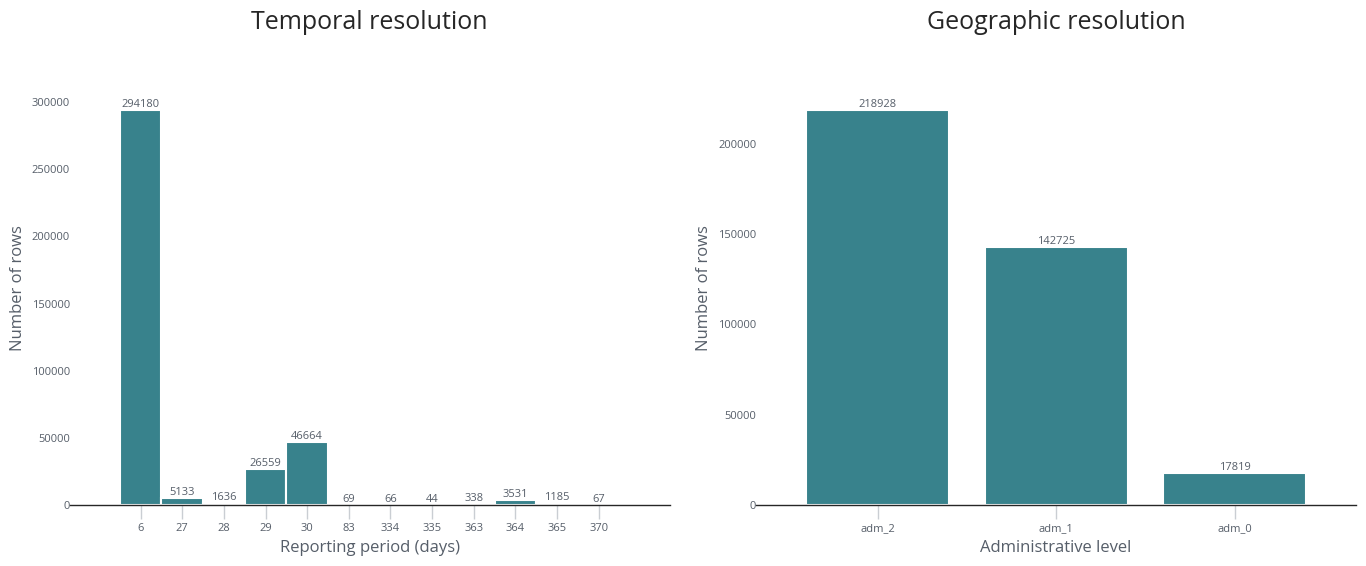

In [105]:
# Create the figure and two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# First subplot: Number of rows by reporting period

trying = pd.Categorical(open_dengue['date_diff'])
reporting_period_counts = pd.Series(trying).value_counts().sort_index()
# reporting_period_counts = open_dengue['date_diff'].value_counts().sort_index()

bars = ax1.bar(reporting_period_counts.index.astype(str), reporting_period_counts.values, color = colors[1], width = 1)

# Adding height labels above each bar
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, height, f'{int(height)}', ha='center', va='bottom', fontsize=8, color=chart[1])


ax1.set_title('Temporal resolution')
ax1.set_xlabel('Reporting period (days)')
ax1.set_ylabel('Number of rows')

# Second subplot: Number of rows by geographic resolution
geo_resolution_counts = open_dengue['geo_resolution'].value_counts()
bars2 = ax2.bar(geo_resolution_counts.index, geo_resolution_counts.values, color=colors[1])

for bar2 in bars2:
    height = bar2.get_height()
    ax2.text(bar2.get_x() + bar2.get_width() / 2, height, f'{int(height)}', ha='center', va='bottom', fontsize=8, color=chart[1])

ax2.set_title('Geographic resolution')
ax2.set_xlabel('Administrative level')
ax2.set_ylabel('Number of rows')

# Display the plots
plt.tight_layout()
plt.show()

### Cases over time
- Roll up to adm0
- Roll up to year
- Include all cases (total, suspected, probable)
- Occurrence map (1+ cases of dengue ever)
- Incidence (new cases over time by country, plot all of them in line chart...and then pull out some interesting examples???)
- Seasonal incidence circular plot....

#### Questions:
- up until what year are open dengue data reliable? e.g., is 2020 complete?

In [109]:
# Extract year from calendar_start_date
open_dengue['year'] = open_dengue['calendar_start_date'].dt.year

# Roll up dengue_total to adm0 level and year level
open_dengue_rollup = open_dengue.groupby(['adm_0_iso3', 'year', 'adm_0_geometry'], as_index=False)['dengue_total'].sum()

open_dengue_rollup.head()

,adm_0_iso3,year,adm_0_geometry,dengue_total
0,AFG,2021,"POLYGON ((66.51861 37.36278, 67.07578 37.35614...",4176.0
1,ARG,1998,"MULTIPOLYGON (((-68.63401 -52.63637, -68.25 -5...",822.0
2,ARG,1999,"MULTIPOLYGON (((-68.63401 -52.63637, -68.25 -5...",1700.0
3,ARG,2000,"MULTIPOLYGON (((-68.63401 -52.63637, -68.25 -5...",1700.0
4,ARG,2001,"MULTIPOLYGON (((-68.63401 -52.63637, -68.25 -5...",11.0


## Geocode

In [9]:
# # GEOCODE places (if needed)
#  user_agent = os.getenv("USER_AGENT")
# geolocator = Nominatim(user_agent=user_agent, timeout=10)

# # Load previously saved geocoded locations to avoid duplicates
# try:
#     with open('../data/cached_locations.pkl', 'rb') as f:
#         cached_locations = pickle.load(f)
# except (FileNotFoundError, EOFError):
#     cached_locations = {}

# def geocode_location(loc):
#     """Geocode the address if not already cached."""
#     if loc in cached_locations:
#         return cached_locations[loc]
#     else:
#         try:
#             location = geolocator.geocode(loc)
#             if location:
#                 # Only return latitude and longitude
#                 lat = location.latitude
#                 long = location.longitude
#                 lat_long = lat, long
#                 cached_locations[loc] = {
#                                     'latitude': lat,
#                                     'longitude': long,
#                                     'lat_long': lat_long
#                 }
#             else:
#                 cached_locations[loc] = None
#             # Save the cache after every new entry
#             with open('cached_locations.pkl', 'wb') as f:
#                 pickle.dump(cached_locations, f)
#             return cached_locations[loc]
#         except Exception as e:
#             print(f"Error geocoding {loc}: {e}")
#             return None

# locs = open_dengue["combined_place"]

# open_dengue["latitude"] = None
# open_dengue["longitude"] = None
# open_dengue["lat_long"] = None


# # Delay between requests in seconds to avoid hitting the rate limit
# REQUEST_DELAY = 0

# # Geocode locations with rate limiting and caching
# for idx, loc in enumerate(locs):
#     coords = geocode_location(loc)
    
#     if coords:
#         open_dengue.at[idx, "latitude"] = coords['latitude']
#         open_dengue.at[idx, "longitude"] = coords['longitude']
#         open_dengue.at[idx, "lat_long"] = coords['lat_long']
#         print(f"Address: {loc}, Coordinates: {coords}")
#     else:
#         print(f"Address: {loc}, Coordinates: Not found")
    
#     # Introduce delay to avoid API rate limits
#     time.sleep(REQUEST_DELAY)